Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os


In [3]:
## If you are using the data by mounting the google drive, use the following :

drive.mount('/content/gdrive')

train_images_path = "/content/gdrive/MyDrive/images/Train"
test_images_path = "/content/gdrive/MyDrive/images/Test"

#seprate folder for keeping augmented images
aug_train_images_path = "/content/gdrive/MyDrive/AugImages/Train"
aug_test_images_path = "/content/gdrive/MyDrive/AugImages/Test"

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(train_images_path)
data_dir_test = pathlib.Path(test_images_path)

aug_data_dir_train = pathlib.Path(aug_train_images_path)
aug_data_dir_test = pathlib.Path(aug_test_images_path)

In [31]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

image_count_train = len(list(aug_data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(aug_data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118
2239
0


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123
epochs = 20

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed=seed,
            label_mode='categorical',
            validation_split = 0.2,
            subset = 'training',
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed=seed,
            label_mode='categorical',
            validation_split = 0.2,
            subset = 'validation',
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
# Define the rescaling layer
rescale = layers.Rescaling(1./255)

# Rescale the images in the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

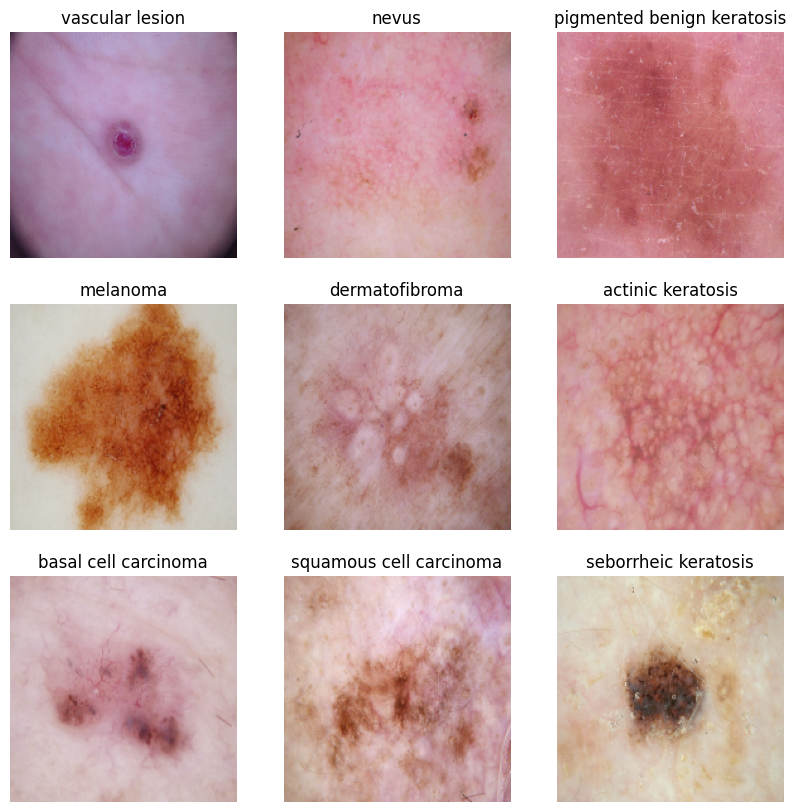

In [12]:

def display_unique_label_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    displayed_labels = set()
    displayed_images = 0

    for images, labels in dataset.unbatch():
        label_idx = np.argmax(labels.numpy())
        #if isinstance(labels.numpy(), np.ndarray) else labels.numpy()
        if label_idx not in displayed_labels:
            ax = plt.subplot(3, 3, displayed_images + 1)
            plt.imshow(images)
            plt.title(class_names[label_idx])
            plt.axis("off")
            displayed_labels.add(label_idx)
            displayed_images += 1
            if displayed_images >= num_images:
                break

display_unique_label_images(train_ds, class_names, num_images=9)
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Compile the model
Choose an appropirate optimiser and loss function for model training

Train the model

# **Model 1**

In [14]:
#Model 1- with 2 layer + same input data
model = models.Sequential()
model.add(Conv2D(32,(3,3),input_shape=(img_height, img_width, 3), padding='same', activation='relu'))
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

# Compiler
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model with early stopping and checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

#train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, shuffle = True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 809s 8s/step - accuracy: 0.2233 - loss: 8.2843 - val_accuracy: 0.4765 - val_loss: 1.7302
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 340s 6s/step - accuracy: 0.4298 - loss: 1.6531 - val_accuracy: 0.4586 - val_loss: 1.6010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 351s 6s/step - accuracy: 0.4800 - loss: 1.4756 - val_accuracy: 0.4922 - val_loss: 1.5037
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 347s 6s/step - accuracy: 0.5581 - loss: 1.2592 - val_accuracy: 0.5369 - val_loss: 1.4109
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 375s 6s/step - accuracy: 0.6530 - loss: 1.0000 - val_accuracy: 0.5078 - val_loss: 1.4959
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 347s 6s/step - accuracy: 0.7244 - loss: 0.8394 - val_accuracy: 0.5190 - val_loss: 1.8497
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 338s 6s/step - accuracy: 0.7676 - loss: 0.6666 - val_accuracy: 0.4966 - val_loss: 2.0227
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 392s 6s/step - accuracy: 0.8162 - loss: 0.5835 - val_accuracy: 0.5011 - v

### Visualizing training results

In [15]:
def display_results():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

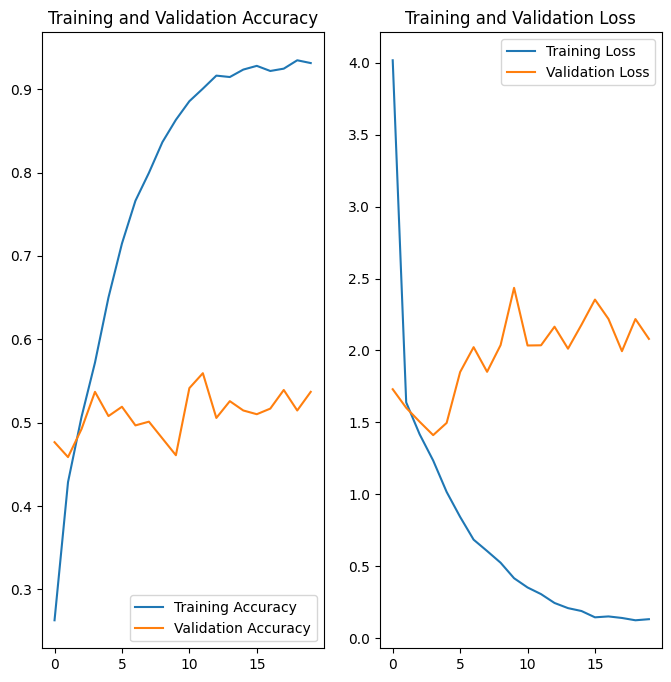

In [16]:
display_results()

**Observation- Overfitting is shown in this model, training data accuracy is 94%  while validation data is 54%**

# **Model 2 - 3 layers, dropouts & normailization**

In [19]:

#Model 2- with 3 layer + dropout + normalization same input data
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

# Compiler
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
# Fit the model with early stopping and checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

#train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, shuffle = True)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 180, 180, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 90, 90, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      33,177,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,273,033 (126.93 MB)

 Trainable params: 33,272,585 (126.92 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 673s 12s/step - accuracy: 0.2319 - loss: 32.7098 - val_accuracy: 0.0425 - val_loss: 87.8374
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 680s 12s/step - accuracy: 0.2014 - loss: 2.2358 - val_accuracy: 0.0425 - val_loss: 116.1270
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 688s 12s/step - accuracy: 0.1963 - loss: 2.1566 - val_accuracy: 0.0515 - val_loss: 105.4091
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 670s 12s/step - accuracy: 0.2155 - loss: 2.1346 - val_accuracy: 0.1253 - val_loss: 79.7116
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 679s 12s/step - accuracy: 0.1965 - loss: 2.1262 - val_accuracy: 0.1477 - val_loss: 53.0012
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 684s 12s/step - accuracy: 0.2107 - loss: 2.1079 - val_accuracy: 0.1387 - val_loss: 27.3183
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 669s 12s/step - accuracy: 0.2067 - loss: 2.0932 - val_accuracy: 0.1946 - val_loss: 10.5377
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 684s 12s/step - accuracy: 0.2040 - loss: 2.0761 - val_ac

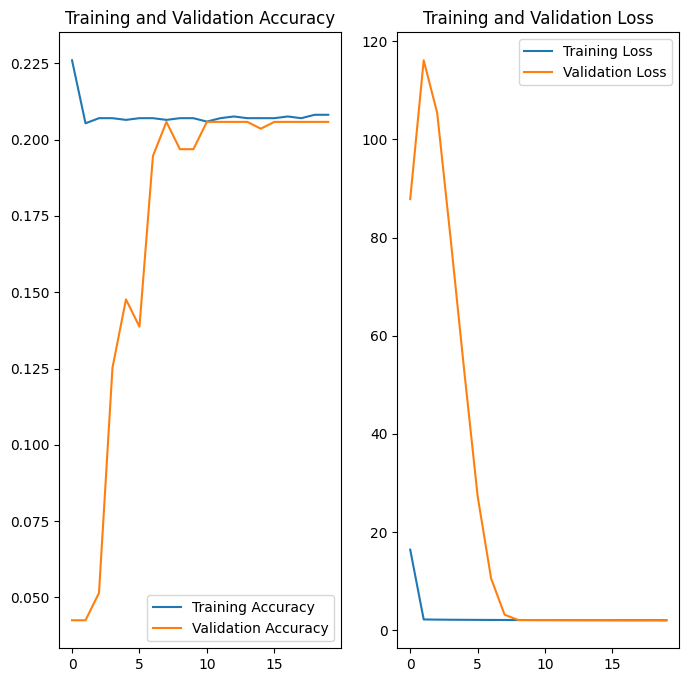

In [30]:
display_results()

### **Observation - Due to addition of new layer, it explode the weights & results in low accuracy**

**Model 2.1- Added learning rate but it didn't executed due to the limited GPU**

In [ ]:
from tensorflow.keras.optimizers import Adam
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(9, activation='softmax'))

# Compiler
model.compile(optimizer=Adam(learning_rate=.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
# Fit the model with early stopping and checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

#train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=5, shuffle = True)

# **Model 3 - data augmentation**

In [ ]:
#Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ]
)

# Apply data augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
#Model 3- put the layers back to 1 & did data augmentation
model = models.Sequential()
model.add(Conv2D(32,(3,3),input_shape=(img_height, img_width, 3), padding='same', activation='relu'))
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

# Compiler
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model with early stopping and checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

#train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, shuffle = True)

Results:

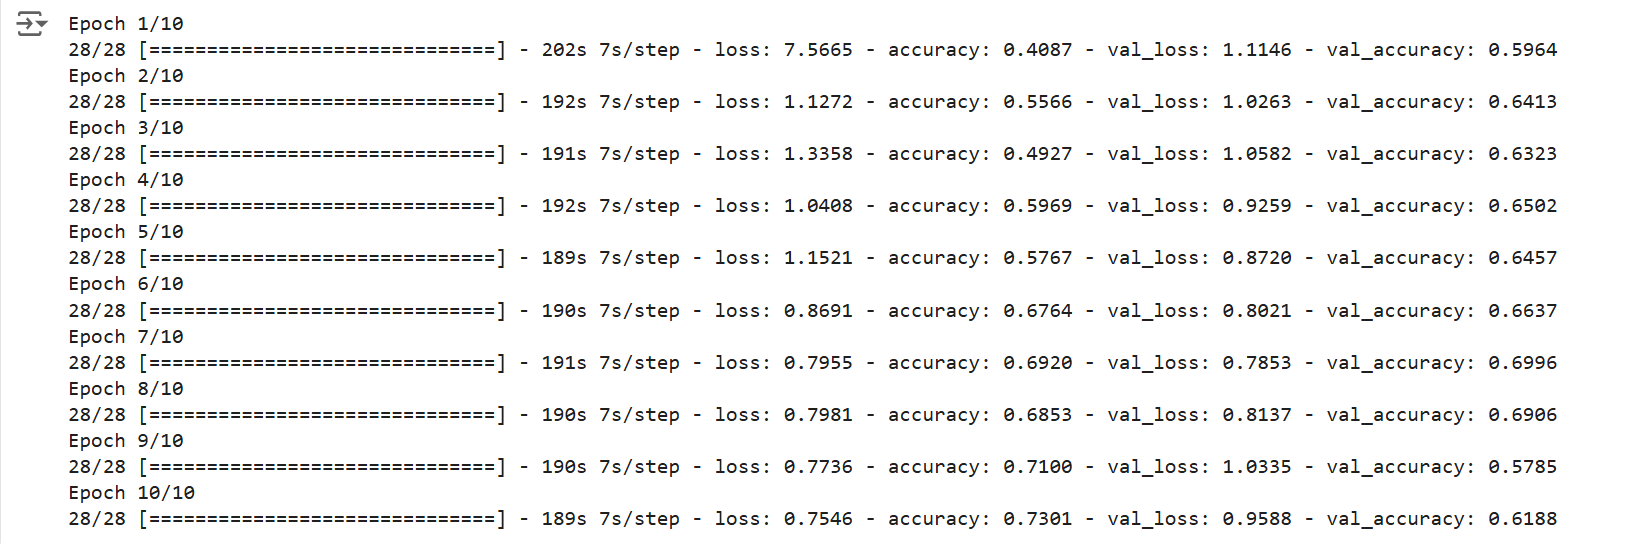

Observation- saw improvements in validation accuracy from 50 to 60%

# **Model 4- Fixing class imbalance**

In [35]:
import os
import shutil
import Augmentor
from pathlib import Path
from collections import Counter

# Define the target number of images per class
target_count = 500

# Create a function to count the number of images in each class
def count_images(directory):
    return len(list(directory.glob('*.jpg')))

# Create augmented images to balance the classes
for class_name in class_names:
    class_dir = aug_data_dir_train / class_name
    current_count = count_images(class_dir)
    samples_needed = target_count - current_count

    if samples_needed > 0:
        p = Augmentor.Pipeline(class_dir)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(samples_needed)

# Move augmented images from 'output' to parent folder
for class_name in class_names:
    output_dir = aug_data_dir_train / class_name / 'output'
    parent_dir = aug_data_dir_train / class_name

    # Check if the output directory exists
    if not output_dir.exists():
        continue

    for file_name in os.listdir(output_dir):
        source = output_dir / file_name
        destination = parent_dir / file_name
        shutil.move(str(source), str(destination))

    # Remove the 'output' directory if it's empty
    if not os.listdir(output_dir):
        os.rmdir(output_dir)


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CDF94D1C90>: 100%|██████████| 386/386 [00:21<00:00, 17.73 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CDF922C640>: 100%|██████████| 124/124 [00:05<00:00, 21.23 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CE19498CA0>: 100%|██████████| 405/405 [00:23<00:00, 17.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x79CDDAF7EB90>: 100%|██████████| 62/62 [00:16<00:00,  3.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CDF9F33820>: 100%|██████████| 143/143 [00:26<00:00,  5.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79CDDB215390>: 100%|██████████| 38/38 [00:01<00:00, 21.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79CE909AF0D0>: 100%|██████████| 423/423 [00:45<00:00,  9.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79CDDAF7F460>: 100%|██████████| 319/319 [00:16<00:00, 19.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/AugImages/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79CE0338DC60>: 100%|██████████| 361/361 [00:20<00:00, 17.38 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(aug_data_dir_train.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

#### **Todo:** Create a training dataset

In [37]:
aug_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            aug_data_dir_train,
            seed=seed,
            label_mode='categorical',
            validation_split = 0.2,
            subset = 'training',
            image_size=(img_height, img_width),
            batch_size=batch_size)


Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [38]:
aug_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            aug_data_dir_train,
            seed=seed,
            label_mode='categorical',
            validation_split = 0.2,
            subset = 'validation',
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [39]:
# Define the rescaling layer
rescale = layers.Rescaling(1./255)

# Rescale the images in the dataset
aug_train_ds = aug_train_ds.map(lambda x, y: (rescale(x), y))
aug_val_ds = aug_val_ds.map(lambda x, y: (rescale(x), y))

In [40]:
aug_train_ds = aug_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
aug_val_ds = aug_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
#Model 4 - After fixing class imbalance problem
model = models.Sequential()
model.add(Conv2D(32,(3,3),input_shape=(img_height, img_width, 3), padding='same', activation='relu'))
model.add(Conv2D(64,(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(9, activation='softmax'))

# Compiler
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model with early stopping and checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

#train the model
history = model.fit(aug_train_ds, validation_data=aug_val_ds, epochs=10, shuffle = True)

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 713s 6s/step - accuracy: 0.1991 - loss: 8.1185 - val_accuracy: 0.3667 - val_loss: 1.6303
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 727s 6s/step - accuracy: 0.4629 - loss: 1.4626 - val_accuracy: 0.4911 - val_loss: 1.4319
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 694s 6s/step - accuracy: 0.5906 - loss: 1.1562 - val_accuracy: 0.5400 - val_loss: 1.2673
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 697s 6s/step - accuracy: 0.7005 - loss: 0.8918 - val_accuracy: 0.6289 - val_loss: 1.1732
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 695s 6s/step - accuracy: 0.7719 - loss: 0.7276 - val_accuracy: 0.6578 - val_loss: 1.1054
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 702s 6s/step - accuracy: 0.8293 - loss: 0.5408 - val_accuracy: 0.5867 - val_loss: 1.2416
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 736s 7s/step - accuracy: 0.8268 - loss: 0.5412 - val_accuracy: 0.6656 - val_loss: 1.2114
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 701s 6s/step - accuracy: 0.8959 - loss: 0.3366 - val_accu

#### **Todo:** Create your model (make sure to include normalization)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Observation- Model 4 when we resovle the classs imbalance problem, we reached the accuracy for train to 92% and for validation data its 70%.**